## Kode

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import cv2
from queue import PriorityQueue

def print_image(img):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            print(f'src {img[i][j]}')  # Updated print syntax

def edit_border(img):
    last_row = img.shape[0] - 1
    last_col = img.shape[1] - 1
    for i in range(img.shape[0]):
        img[i,0] = 0
        img[i,last_col] = 0
    for i in range(img.shape[1]):
        img[0,i] = 0
        img[last_row,i] = 0

def fms(i1, j1, i2, j2, f, t):
    a1 = t[i1,j1]
    a2 = t[i2,j2]
    m = min(a1,a2)
    if f[i1,j1] != 2:
        if f[i2,j2] != 2:
            if abs(a1-a2) >= 1.0:
                ret = 1.0 + m
            else:
                ret = 0.5*(a1 + a2 + np.sqrt(2.0-(a1-a2)*(a1-a2)))
        else:
            ret = 1.0 + a1
    elif f[i2,j2] != 2:
        ret = 1.0 + a2
    else:
        ret = 1.0 + m
    return ret

def min4(a1, a2, a3, a4):
    return min(min(a1, a2), min(a3, a4))

def inpaint_point(i, j, f, t, ret, epsilon):
    radius_sqr = float(epsilon*epsilon)

    grad_tx = 0.0
    grad_ty = 0.0

    # Calculate X gradient
    if f[i,j+1] != 2:
        if f[i,j-1] != 2:
            grad_tx = 0.5*(t[i,j+1] - t[i,j-1])
        else:
            grad_tx = (t[i,j+1] - t[i,j])
    elif f[i,j-1] != 2:
        grad_tx = (t[i,j] - t[i,j-1])

    # Calculate Y gradient
    if f[i+1,j] != 2:
        if f[i-1,j] != 2:
            grad_ty = 0.5*(t[i+1,j] - t[i-1,j])
        else:
            grad_ty = (t[i+1,j] - t[i,j])
    elif f[i-1,j] != 2:
        grad_ty = (t[i,j] - t[i-1,j])

    min_i = max(1, i - epsilon)
    min_j = max(1, j - epsilon)
    max_i = min(ret.shape[0] - 1, i + epsilon + 1)
    max_j = min(ret.shape[1] - 1, j + epsilon + 1)

    if len(ret.shape) == 3:
        Ia = np.zeros(3, dtype=np.float32)
        Ix = np.zeros(3, dtype=np.float32)
        Iy = np.zeros(3, dtype=np.float32)
        s = 1.0e-20

        for k in range(min_i, max_i):
            for l in range(min_j, max_j):
                r_y = float(i - k)
                r_x = float(j - l)
                if (f[k,l] != 2) and ((r_x*r_x + r_y*r_y) <= radius_sqr):
                    dst = 1.0/((r_x*r_x + r_y*r_y)*np.sqrt(r_x*r_x + r_y*r_y))
                    lev = 1.0/(1.0 + abs(t[k,l] - t[i,j]))
                    dir_t = ((grad_tx * r_x) + (grad_ty * r_y))
                    if abs(dir_t) <= 0.01:
                        dir_t = 0.000001
                    w = abs(dst*lev*dir_t)

                    grad_ix = np.zeros(3)
                    grad_iy = np.zeros(3)

                    # Calculate X gradients
                    if f[k,l+1] != 2:
                        if f[k,l-1] != 2:
                            grad_ix = 0.5*(ret[k,l+1,:] - ret[k,l-1,:])
                        else:
                            grad_ix = ret[k,l+1,:] - ret[k,l,:]
                    elif f[k,l-1] != 2:
                        grad_ix = ret[k,l,:] - ret[k,l-1,:]

                    # Calculate Y gradients
                    if f[k+1,l] != 2:
                        if f[k-1,l] != 2:
                            grad_iy = 0.5*(ret[k+1,l,:] - ret[k-1,l,:])
                        else:
                            grad_iy = ret[k+1,l,:] - ret[k,l,:]
                    elif f[k-1,l] != 2:
                        grad_iy = ret[k,l,:] - ret[k-1,l,:]

                    Ia += w * ret[k,l,:]
                    Ix -= w * r_x * grad_ix
                    Iy -= w * r_y * grad_iy
                    s += w

        for c in range(3):
            ret[i,j,c] = 0.5 + (Ia[c]/s) + (Ix[c]+Iy[c])/(np.sqrt(Ix[c]*Ix[c]+Iy[c]*Iy[c])+1.0e-20)

    else:
        Ia = 0.0
        Ix = 0.0
        Iy = 0.0
        s = 1.0e-20

        for k in range(min_i, max_i):
            for l in range(min_j, max_j):
                r_y = i - k
                r_x = j - l
                if (f[k,l] != 2) and ((r_x*r_x + r_y*r_y) <= radius_sqr):
                    dst = 1.0/((float(r_x*r_x + r_y*r_y))*(np.sqrt(r_x*r_x + r_y*r_y)))
                    lev = 1.0/(1.0 + abs(t[k,l] - t[i,j]))
                    dir_t = ((grad_tx * float(r_x)) + (grad_ty * float(r_y)))
                    if abs(dir_t) <= 0.01:
                        dir_t = 0.000001
                    w = abs(dst*lev*dir_t)

                    grad_ix = 0.0
                    grad_iy = 0.0

                    # Calculate gradients
                    if f[k,l+1] != 2:
                        if f[k,l-1] != 2:
                            grad_ix = 0.5*(ret[k,l+1] - ret[k,l-1])
                        else:
                            grad_ix = ret[k,l+1] - ret[k,l]
                    elif f[k,l-1] != 2:
                        grad_ix = ret[k,l] - ret[k,l-1]

                    if f[k+1,l] != 2:
                        if f[k-1,l] != 2:
                            grad_iy = 0.5*(ret[k+1,l] - ret[k-1,l])
                        else:
                            grad_iy = ret[k+1,l] - ret[k,l]
                    elif f[k-1,l] != 2:
                        grad_iy = ret[k,l] - ret[k-1,l]

                    Ia += w * ret[k,l]
                    Ix -= w * grad_ix * float(r_x)
                    Iy -= w * grad_iy * float(r_y)
                    s += w

        ret[i,j] = 0.5 + (Ia/s) + (Ix+Iy)/(np.sqrt(Ix*Ix+Iy*Iy)+1.0e-20)

def telea(f, t, ret, epsilon, heap):
    while not heap.empty():
        val_t, (r,c) = heap.get()
        f[r,c] = 0

        # Check neighboring pixels
        neighbors = [(r-1,c), (r+1,c), (r,c-1), (r,c+1)]
        for i, j in neighbors:
            if f[i,j] == 2:
                dist = min4(
                    fms(i-1,j,i,j-1,f,t),
                    fms(i+1,j,i,j-1,f,t),
                    fms(i-1,j,i,j+1,f,t),
                    fms(i+1,j,i,j+1,f,t)
                )
                t[i,j] = dist
                inpaint_point(i, j, f, t, ret, epsilon)
                f[i,j] = 1
                heap.put((dist, (i,j)))

def inpaint_image(img, inpaint_mask, epsilon):
    print('InPainting Started')

    # Pad the image
    pad_row = img.shape[0] + 2
    pad_col = img.shape[1] + 2

    # Create kernels
    cross_kernel = np.array([
        [0, 1, 0],
        [1, 1, 1],
        [0, 1, 0]
    ], dtype=np.uint8)

    rect_size = 2 * epsilon + 1
    rect_kernel = np.ones((rect_size, rect_size), np.uint8)

    # Initialize padded output array
    if len(img.shape) == 2:
        ret = np.pad(img, ((1,1), (1,1)), mode='edge')
    else:
        ret = np.pad(img, ((1,1), (1,1), (0,0)), mode='edge')

    ret = ret.astype(float)

    # Initialize distance and mask arrays
    t = np.full((pad_row, pad_col), 1.0e6, dtype=float)
    mask = np.zeros((pad_row, pad_col), dtype=np.uint8)
    mask[1:-1, 1:-1] = 2 * (inpaint_mask / 255)

    # Create band
    band = cv2.dilate(mask, cross_kernel) - mask
    edit_border(band)

    # Initialize heaps
    heap = PriorityQueue()
    heap_out = PriorityQueue()

    t[band == 2] = 0.0

    for r in range(pad_row):
        for c in range(pad_col):
            if band[r,c] == 2:
                heap.put((0.0, (r,c)))
                heap_out.put((0.0, (r,c)))

    # Create outside region
    out = cv2.dilate(mask, rect_kernel) - mask - band
    edit_border(out)

    print('Initialization Completed')

    # Process outside region
    while not heap_out.empty():
        val_t, (r,c) = heap_out.get()
        out[r,c] = 3

        neighbors = [(r-1,c), (r+1,c), (r,c-1), (r,c+1)]
        for i, j in neighbors:
            if out[i,j] == 2:
                dist = min4(
                    fms(i-1,j,i,j-1,out,t),
                    fms(i+1,j,i,j-1,out,t),
                    fms(i-1,j,i,j+1,out,t),
                    fms(i+1,j,i,j+1,out,t)
                )
                t[i,j] = dist
                out[i,j] = 1
                heap_out.put((dist, (i,j)))

    t[out == 3] *= -1

    print('Preprocessing Completed')
    telea(mask, t, ret, epsilon, heap)
    print('Completed')

    return ret[1:-1, 1:-1].astype(np.uint8)

def inpaint(img, mask, epsilon):
    return inpaint_image(img, mask, epsilon)

## Gambar Foto Terlipat

In [ ]:
image = files.upload()

Saving 1.jpg to 1.jpg


In [ ]:
mask = files.upload()

Saving 2.jpg to 2.jpg


In [ ]:
img = cv2.imread('1.jpg')
mask = cv2.imread('2.jpg', cv2.IMREAD_GRAYSCALE)

In [ ]:
_, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

(-0.5, 959.5, 539.5, -0.5)

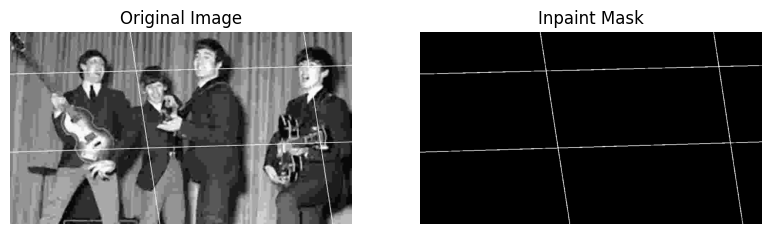

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(binary_mask, cmap='gray')
plt.title('Inpaint Mask')
plt.axis('off')

In [ ]:
epsilon = 5
output_image = inpaint(img, binary_mask, epsilon)

InPainting Started
Initialization Completed
Preprocessing Completed
Completed


(-0.5, 959.5, 539.5, -0.5)

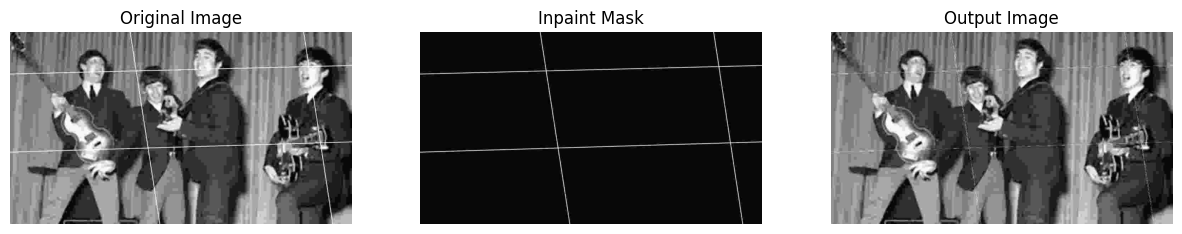

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title('Inpaint Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(output_image, cmap='gray')
plt.title('Output Image')
plt.axis('off')

## Tulisan diatas Gambar

In [ ]:
image = files.upload()

Saving image1_resize1.jpg to image1_resize1.jpg


In [ ]:
mask = files.upload()

Saving mask1_resize1.jpg to mask1_resize1.jpg


In [ ]:
img1 = cv2.imread('image1_resize1.jpg')
mask1 = cv2.imread('mask1_resize1.jpg', cv2.IMREAD_GRAYSCALE)

In [ ]:
_, binary_mask1 = cv2.threshold(mask1, 127, 255, cv2.THRESH_BINARY)

(-0.5, 959.5, 539.5, -0.5)

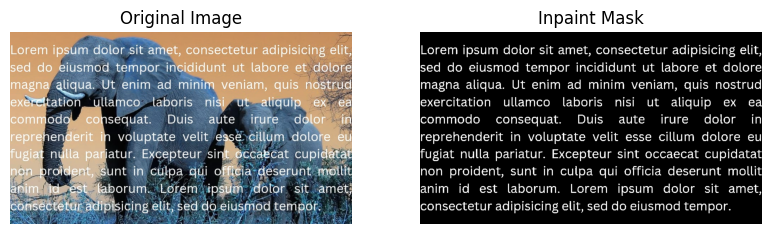

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img1)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(binary_mask1, cmap='gray')
plt.title('Inpaint Mask')
plt.axis('off')

In [ ]:
epsilon = 5
output_image = inpaint(img1, binary_mask1, epsilon)

InPainting Started
Initialization Completed
Preprocessing Completed
Completed


(-0.5, 959.5, 539.5, -0.5)

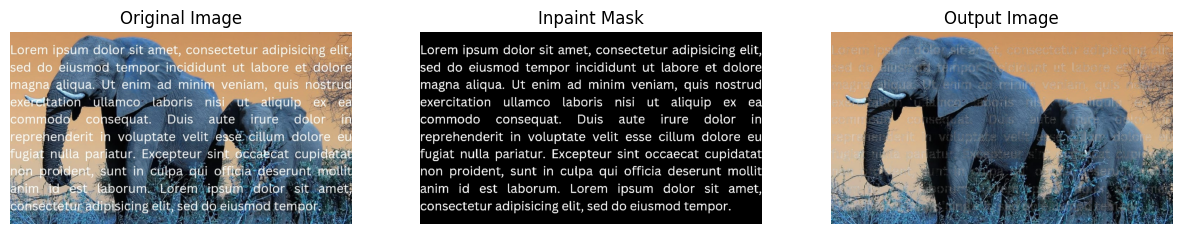

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img1)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(binary_mask1, cmap='gray')
plt.title('Inpaint Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(output_image, cmap='gray')
plt.title('Output Image')
plt.axis('off')